<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/project_example_added/projects/modelingsteps/MoVi_motion_classification_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Data Science Project: MoVi motion classification demo project

**By Neuromatch Academy**

__Content creators:__ Marius 't Hart, Megan Peters, Vladimir Haltakov, Paul Schrater, Gunnar Blohm

__Production editor:__ Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objectives

We're interested in automatically classifying movement. There is a great dataset (MoVi) with different modalities of movement recordings (videos, visual markers, accelerometers, skeletal motion reconstructions, etc). We will use a sub-set of this data, i.e. estimated skeletal motion, to perform a pilot study investigating whether we can classify different movements from the skeletal motion. And if so, which skeletal motions (if not all) are neccessary for good decoding performance?

Please check out the different resources below to better understand the MoVi dataset and learn more about the movements.

**Resources**:
* [see MoVi paper here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0253157)
* [GitHub page of MoVi](https://github.com/saeed1262/MoVi-Toolbox)
* [MoVi website and description](https://www.biomotionlab.ca/movi/)
* [full MoVi dataset (not needed for this demo)](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/JRHDRN)

---
# Setup

For your own project, you can put together a colab notebook by copy-pasting bits of code from the tutorials. We still recommend keeping the 4 setup cells at the top, like here; Imports, Figure Settings, Plotting functions, and Data retrieval.

In [1]:
# Imports
# get some matrices and plotting:
import numpy as np
import matplotlib.pyplot as plt

# get some pytorch:
import torch
import torch.nn as nn
from torch.nn import MaxPool1d
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# confusion matrix from sklearn
from sklearn.metrics import confusion_matrix

# to get some idea of how long stuff will take to complete:
import time

# to see how unbalanced the data is:
from collections import Counter

In [2]:
# @title Figure settings
import ipywidgets as widgets #interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [3]:
# @title Plotting functions

def plotConfusionMatrix(real_labels, predicted_labels, label_names):

  # conver the labels to integers:
  real_labels = [int(x) for x in real_labels]
  predicted_labels = [int(x) for x in predicted_labels]
  tick_names = [a.replace("_", " ") for a in label_names]
  
  cm = confusion_matrix(real_labels, predicted_labels, normalize='true')
  
  fig = plt.figure(figsize=(8,6))
  plt.imshow(cm)
  plt.xticks(range(len(tick_names)),tick_names, rotation=90)
  plt.yticks(range(len(tick_names)),tick_names)
  plt.xlabel('predicted move')
  plt.ylabel('real move')
  plt.show()

In [4]:
# @title Data retrieval
# @markdown Run this cell to download the data for this example project.
import io
import requests
r = requests.get('https://osf.io/mnqb7/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  train_moves=np.load(io.BytesIO(r.content), allow_pickle=True)['train_moves']
  train_labels=np.load(io.BytesIO(r.content), allow_pickle=True)['train_labels']
  test_moves=np.load(io.BytesIO(r.content), allow_pickle=True)['test_moves']
  test_labels=np.load(io.BytesIO(r.content), allow_pickle=True)['test_labels']
  label_names=np.load(io.BytesIO(r.content), allow_pickle=True)['label_names']
  joint_names=np.load(io.BytesIO(r.content), allow_pickle=True)['joint_names']

---
# Step 1: Question
There are many different questions we could ask with the MoVi dataset. We will start with a simple question: **"Can we classify movements from skeletal motion data, and if so, which body parts are the most informative ones?"**

Our goal is to perform a *pilot* study to see if this is possible in principle. We will therefore use "ground truth" skeletal motion data that has been computed using an inference algorithm (see [MoVi paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0253157)). If this works out, then as a next step we might want to use the raw sensor data or even videos...

The ultimate goal could for example be to figure out which body parts to record movements from (e.g. is just a wristband enough?) to classify movement.

---
# Step 2: literature review
Most importantly, our literature review needs to address the following:
* what modeling approaches make it possible to classify time series data?
* how is human motion captured?
* what exactly is in the MoVi dataset?
* what is known regarding classification of human movement based on different measurements?

What we learn from the literature review is too long to write out here... But we would like to point out that human motion classification has been done; we're not proposing a very novel project here. But that's ok for an NMA project!

---
# Step 3: ingredients

## Data ingredients

After downloading the data, we should have 6 numpy arrays:

- `train_moves`: the training set of 1032 movements
- `train_labels`: the class labels for each of the 1032 training movements
- `test_moves`: the test set of 172 movements
- `test_labels`: the class labels for each of the 172 test movements
- `label_names`: text labels for the values in the two arrays of class labels
- `joint_names`: the names of the 24 joints used in each movement

We'll take a closer look at the data below. *Note*: data is split into training and test sets. If you don't know what that means, NMA-DL will teach you!

**Inputs**:

For simplicity, we take the first 24 joints of the whole MoVi dataset including all major limbs. The data was in an exponential map format, which has 3 rotations/angles for each joint (pitch, yaw, roll). The advantage of this type of data is that it is (mostly) agnostic about body size or shape. And since we care about movements only, we choose this representation of the data (there are other representations in the full data set).

Since the joints are simply points, the 3rd angle (i.e. roll) contained no information, and that is already dropped from the data that we pre-formatted for this demo project. That is, the movements of each joint are described by 2 angles, that change over time. Furthermore, we normalized all the angles/rotations to fall between 0 and 1 so they are good input for PyTorch.

Finally, the movements originally took various amounts of time, but we need the same input for each movement, so we sub-sampled and (linearly) interpolated the data to have 75 timepoints.

Our training data is supposed to have 1032 movements, 2 x 24 joints = 48 channels and 75 timepoints. Let's check and make sure:

In [5]:
print(train_moves.shape)

(1032, 48, 75)


Cool!

**Joints**:

For each movement we have 2 angles from 24 joints. Which joints are these?

In [6]:
for joint_no in range(24):
  print(f"{joint_no}: {joint_names[joint_no]}")

0: Pelvis
1: LeftHip
2: RightHip
3: Spine1
4: LeftKnee
5: RightKnee
6: Spine2
7: LeftAnkle
8: RightAnkle
9: Spine3
10: LeftFoot
11: RightFoot
12: Neck
13: LeftCollar
14: RightCollar
15: Head
16: LeftShoulder
17: RightShoulder
18: LeftElbow
19: RightElbow
20: LeftWrist
21: RightWrist
22: LeftHand
23: RightHand


**Labels**:

Let's have a look at the `train_labels` array too:

In [7]:
print(train_labels)
print(train_labels.shape)

[ 0  1  4 ...  6  2 11]
(1032,)


The labels are numbers, and there are 1032 of them, so that matches the number of movements in the data set. There are text versions too in the array called `label_names`. Let's have a look. There are supposed to be 14 movement classes.



In [8]:
# let's check the values of the train_labels array:
label_numbers = np.unique(train_labels)
print(label_numbers)

# and use them as indices into the label_names array:
for label_no in label_numbers:
  print(f"{label_no}: {label_names[label_no]}")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
0: crawling
1: throw/catch
2: walking
3: running_in_spot
4: cross_legged_sitting
5: hand_clapping
6: scratching_head
7: kicking
8: phone_talking
9: sitting_down
10: checking_watch
11: pointing
12: hand_waving
13: taking_photo


The test data set has similar data, but fewer movements. That's ok. What's important is that both the training and test datasets have an even spread of movement types, i.e. we want them to be balanced. Let's see how balanced the data is:

In [9]:
Counter(train_labels)

Counter({0: 74,
         1: 74,
         2: 73,
         3: 73,
         4: 73,
         5: 73,
         6: 74,
         7: 74,
         8: 74,
         9: 74,
         10: 74,
         11: 74,
         12: 74,
         13: 74})

In [10]:
Counter(test_labels)

Counter({0: 12,
         1: 12,
         2: 13,
         3: 13,
         4: 13,
         5: 13,
         6: 12,
         7: 12,
         8: 12,
         9: 12,
         10: 12,
         11: 12,
         12: 12,
         13: 12})

So that looks more or less OK. Movements 2, 3, 4 and 5 occur once more in the training data than the other movements, and one time fewer in the test data. Not perfect, but probably doesn't matter that much.

## Model ingredients

**"Mechanisms"**:

* Feature engineering? --> Do we need anything else aside from angular time courses? For now we choose to only use the angular time courses (exponential maps), as our ultimate goal is to see how many joints we need for accurate movement classification so that we can decrease the number of measurements or devices for later work.

* Feature selection? --> Which joint movements are most informative? These are related to our research questions and hypotheses, so this project will explicitly investigate which joints are most informative.

* Feature grouping? --> Instead of trying all possible combinations of joints (very many) we could focus on limbs, by grouping joints. We could also try the model on individual joints.

* Classifier? --> For our classifier we would like to keep it as simple as possible, but we will decide later.

* Input? --> The training data (movements and labels) will be used to train the classifier.

* Output? --> The test data will be used as input for the trained model and we will see if the predicted labels are the same as the actual labels.

---
# Step 4: hypotheses
Since humans can easily distinguish different movement types from video data and also more abstract "stick figures", a DL model should also be able to do so. Therefore, our hypotheses are more detailed with respect to parameters influencing model performance (and not just whether it will work or not). 

Remember, we're interested in seeing how many joints are needed for classification. So we could hypothezise (Hypothesis 1) that arm and leg motions are sufficient for classification (meaning: head and torso data is not needed).

* Hypothesis 1: The performance of a model with four limbs plus torso and head is not higher than the performance of a model with only limbs.

We could also hypothesize that data from only one side of the body is sufficient (Hypothesis 2), e.g. the right side, since our participants are right handed.

* Hypothesis 2: A model using only joints in the right arm will outperform a model using only the joints in the left arm.

Writing those in mathematical terms:
* Hypothesis 1: $\mathbb{E}(perf_{limbs})>\mathbb{E}(perf_{torso})$
* Hypothesis 2: $\mathbb{E}(perf_{right arm})>\mathbb{E}(perf_{left arm})$

---
# Step 5: toolkit selection
We need a toolkit that can deal with time-varying data as input (e.g. 1d convnet, LSTM, transformer...). We want to keep it as simple as possible to start with. So let's run with a 1d convnet. It allows us to answer our question, it will be able to speak to our hypotheses, and hopefully we can achieve our goal to see if automatic movement classification based on (sparse) body movement data is possible.

---
# Step 6: model drafting
Here is our sketch of the model we wanted to build...

<p align='center'><img src='https://github.com/NeuromatchAcademy/course-content-dl/blob/main/projects/static/DL_model_schematic.jpg?raw=True'/></p>

---
# Step 7: model implementation

It's finally time to write some deep learning code... so here we go!

The cell below creates an object class, and is based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html on the PyTorch website, adapted to work with our data.

It is based on the `Dataset` object class in PyTorch and this is needed to set up a `Dataloader` object that will be used in the model.

We can tell our dataset object to use the training or test data. We can also tell it which joints to return, so that we can build models that classify movements based on different sets of joints:

In [11]:
class MoViJointDataset(Dataset):
  """MoVi dataset."""
  
  def __init__(self, train=True, joints=list(range(24))):
    """
    Args:
      train (boolean): Use the training data, or otherwise the test data.
      joints (list): Indices of joints to return.
    """
    
    # select the training or test data:
    if train:
      self.moves = train_moves
      self.labels = train_labels
    else:
      self.moves = test_moves
      self.labels = test_labels
    
    # convert joint indices to channel indices:
    joints = np.array(joints)
    self.channels = np.sort(list(joints*2)+ list((joints*2)+1)) # 2 channels per joint
      
  def __len__(self):
    return self.labels.size

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    sample = (np.float32(np.squeeze(self.moves[idx,self.channels,:])), self.labels[idx])

    return sample

We want to make sure that this object works the way we intended, so we try it out:

In [12]:
# Create training and test datasets
movi_train = MoViJointDataset(train=True)
movi_test = MoViJointDataset(train=False, joints=[0,1,2])

print('TRAINING:')
for idx in range(len(movi_train)):
  pass
print(idx)
print(movi_train[idx][0].shape, label_names[movi_train[idx][1]])
print('\nTESTING:')
for idx in range(len(movi_test)):
  pass
print(idx)
print(movi_test[idx][0].shape, label_names[movi_test[idx][1]])

TRAINING:
1031
(48, 75) pointing

TESTING:
171
(6, 75) cross_legged_sitting


So we see the movement number (minus 1), the shape of the dataset (e.g. 48 channels and 75 time points for the training set), and the name of the movement.

## Build model
pytorch expects as input not a single sample, but rather a minibatch of B samples stacked together along the "minibatch dimension".
So a "1D" CNN in pytorch expects a 3D tensor as input: BxCxT

- **B:** batch size (however many examples are used in batch training)
- **C:** channels (up to 24 joints x 2 coordinates)
- **T:** timepoints (75 in our case)

We need `Dataloader` objects that use our `MoViJointDataset` objects to do this. For this we can simply use PyTorch `Dataloader` objects, but it also needs one of our hyperparameters (batch size) to be set:

In [13]:
# Hyperparameters
num_epochs = 500
num_classes = 14 # is this ever used?
batch_size = 516
learning_rate = 0.001

# Create training and test datasets
movi_train = MoViJointDataset(train = True)
movi_test  = MoViJointDataset(train = False)

# Data loader
train_loader = DataLoader(dataset=movi_train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=movi_test, batch_size=batch_size, shuffle=False)

And we decided to use a simple 1D convnet. We want to specify the number of joints used and then use 2 input channels for every joint (2 dimensions of rotation). At the end of the convnet there are 14 probabilities, 1 for each class of movement, but we convert it to give the index of the highest probability.

In [14]:
class Mov1DCNN(nn.Module):
  def __init__(self, njoints=24):
      
    super(Mov1DCNN, self).__init__()
    
    self.layer1 = nn.Sequential(
      nn.Conv1d(in_channels=njoints*2, out_channels=56, kernel_size=5, stride=2),
      nn.ReLU(),
      nn.MaxPool1d(kernel_size=2, stride=2))
    
    self.layer2 = nn.Sequential(
      nn.Conv1d(in_channels=56, out_channels=14, kernel_size=1),
      nn.ReLU(),
      nn.MaxPool1d(kernel_size=2, stride=2))
    
    self.dropout1 = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(126, 2200)  # fix dimensions
    self.nl = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(2200, 14)
  
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    
    out = out.reshape(out.size(0), -1)
    out = self.dropout1(out)
    out = self.fc1(out)
    out = self.nl(out)
    out = self.dropout2(out)
    out = self.fc2(out)
    # pick the most likely class:
    out = nn.functional.log_softmax(out, dim=1)

    return out

We can now instantiate the model object, with _all_ joints, and set a criterion and optimizer: 

In [15]:
### ADDING GPU ###
device = "cuda" if torch.cuda.is_available() else "cpu"

# create the model object:
model = Mov1DCNN(njoints=24).to(device)

# loss and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

And now we are ready to train this model.

**This takes up to ~20 seconds!**

In [16]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
  for i, (motions, labels) in enumerate(train_loader):
    motions, labels = motions.to(device), labels.to(device)

    # Run the forward pass
    outputs = model(motions)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], "
              f"Loss: {loss.item():.4f}, "
              f"Accuracy: {((correct / total) * 100):.2f}%")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/500], Step [2/2], Loss: 2.6440, Accuracy: 7.75%
Epoch [2/500], Step [2/2], Loss: 2.6410, Accuracy: 6.40%
Epoch [3/500], Step [2/2], Loss: 2.6397, Accuracy: 6.78%
Epoch [4/500], Step [2/2], Loss: 2.6397, Accuracy: 6.01%
Epoch [5/500], Step [2/2], Loss: 2.6371, Accuracy: 6.98%
Epoch [6/500], Step [2/2], Loss: 2.6371, Accuracy: 6.20%
Epoch [7/500], Step [2/2], Loss: 2.6330, Accuracy: 9.50%
Epoch [8/500], Step [2/2], Loss: 2.6276, Accuracy: 16.09%
Epoch [9/500], Step [2/2], Loss: 2.6221, Accuracy: 7.56%
Epoch [10/500], Step [2/2], Loss: 2.6048, Accuracy: 13.76%
Epoch [11/500], Step [2/2], Loss: 2.5949, Accuracy: 16.67%
Epoch [12/500], Step [2/2], Loss: 2.5624, Accuracy: 21.71%
Epoch [13/500], Step [2/2], Loss: 2.5356, Accuracy: 21.32%
Epoch [14/500], Step [2/2], Loss: 2.5079, Accuracy: 20.54%
Epoch [15/500], Step [2/2], Loss: 2.4446, Accuracy: 24.22%
Epoch [16/500], Step [2/2], Loss: 2.4058, Accuracy: 24.42%
Epoch [17/500], Step [2/2], Loss: 2.3785, Accuracy: 18.80%
Epoch [18/500]

The training accuracy usually starts out below 10%, which makes sense as chance 100/14 = 7%. It usually quickly goes up to around 80%. The model can get better if you run more epochs, but this is sufficient for now. 

 Now we want to see performance on the test data set:

In [17]:
# Test the model
model.eval()
real_labels, predicted_labels = [], []
with torch.no_grad():
  correct = 0
  total = 0
  for motions, labels in test_loader:
    motions, labels = motions.to(device), labels.to(device)
    real_labels += list(labels)
    outputs = model(motions)
    _, predicted = torch.max(outputs.data, 1)
    predicted_labels += list(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(f"Test Accuracy of the model on the 172 test moves: {(correct / total)*100:.3f}%")

Test Accuracy of the model on the 172 test moves: 73.837%


Considering that we have a relatively small data set, and a fairly simple model that didn't really converge, this is decent performance (chance is ~7%). Let's look at where the errors are:

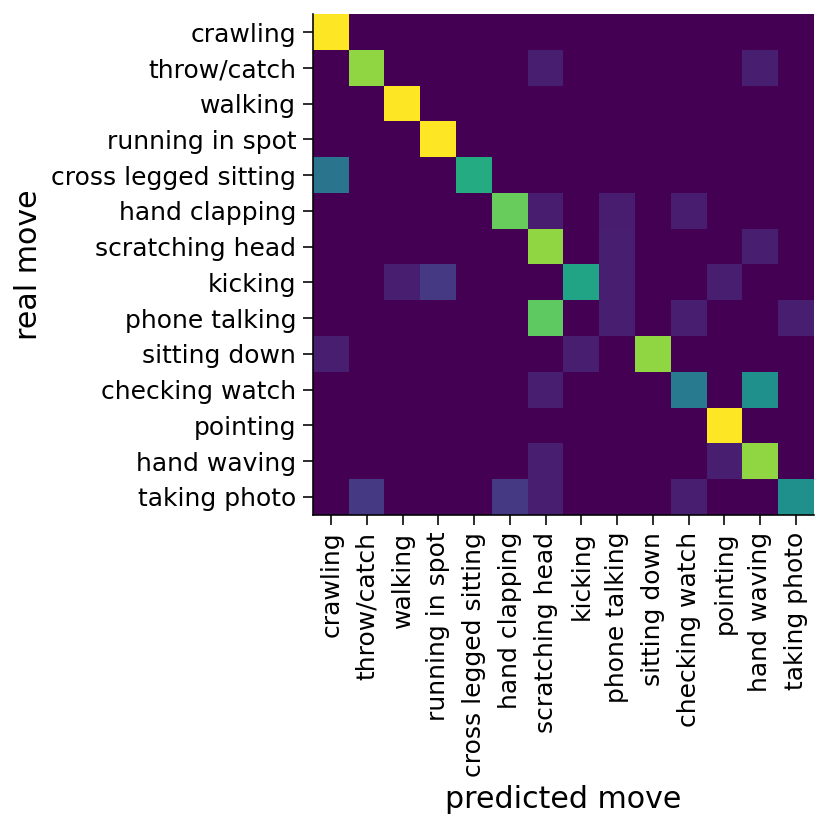

In [18]:
# plt.style.use('dark_background')  # uncomment if you're using dark mode...
plotConfusionMatrix(real_labels, predicted_labels, label_names)

The errors vary each time the model is run, but a common error seems to be that head scratching is predicted from some other movements that also involve arms a lot: throw/catch, hand clapping, phone talking, checking watch, hand waving, taking photo. If we train the model longer, these errors tend to go away as well. For some reason, crossed legged sitting is sometimes misclassified for crawling, but this doesn't always happen.

---
# Step 8: Modeling completion

Are we done yet? In order to answer our questions, reach our goals and evaluate our hypotheses we need to be able to get test performance from the model, and might want to investigate any errors that the model makes. We will first make a function that fits the model on a specified set of joints


In [19]:
def testJointModel(joints=list(range(24)),
                   num_epochs = 500,
                   batch_size=516,
                   learning_rate = 0.001):

  # Hyperparameters
  num_classes = 14
  
  # Create training and test datasets
  movi_train = MoViJointDataset(train  = True, joints = joints)
  movi_test  = MoViJointDataset(train  = False, joints = joints)

  # Data loaders
  train_loader = DataLoader(dataset=movi_train, batch_size=batch_size, shuffle=True)
  test_loader  = DataLoader(dataset=movi_test, batch_size=batch_size,  shuffle=False)

  # create the model object:
  model = Mov1DCNN(njoints=len(joints)).to(device)

  # loss and optimizer:
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
    for i, (motions, labels) in enumerate(train_loader):
      motions, labels = motions.to(device), labels.to(device)

      # Run the forward pass
      outputs = model(motions)
      loss = criterion(outputs, labels)
      loss_list.append(loss.item())

      # Backprop and perform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
  
  # Test the model
  model.eval()
  real_labels, predicted_labels = [], []
  with torch.no_grad():
    correct = 0
    total = 0
    for motions, labels in test_loader:
      motions, labels = motions.to(device), labels.to(device)
      real_labels += list(labels)
      outputs = model(motions)
      _, predicted = torch.max(outputs.data, 1)
      predicted_labels += list(predicted)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  performance = (correct / total) * 100

  return {'performance': performance,
          'real_labels': real_labels,
          'predicted_labels': predicted_labels}

Let's test this on a few select joints:

**This takes up to ~10 seconds:**

68.6046511627907


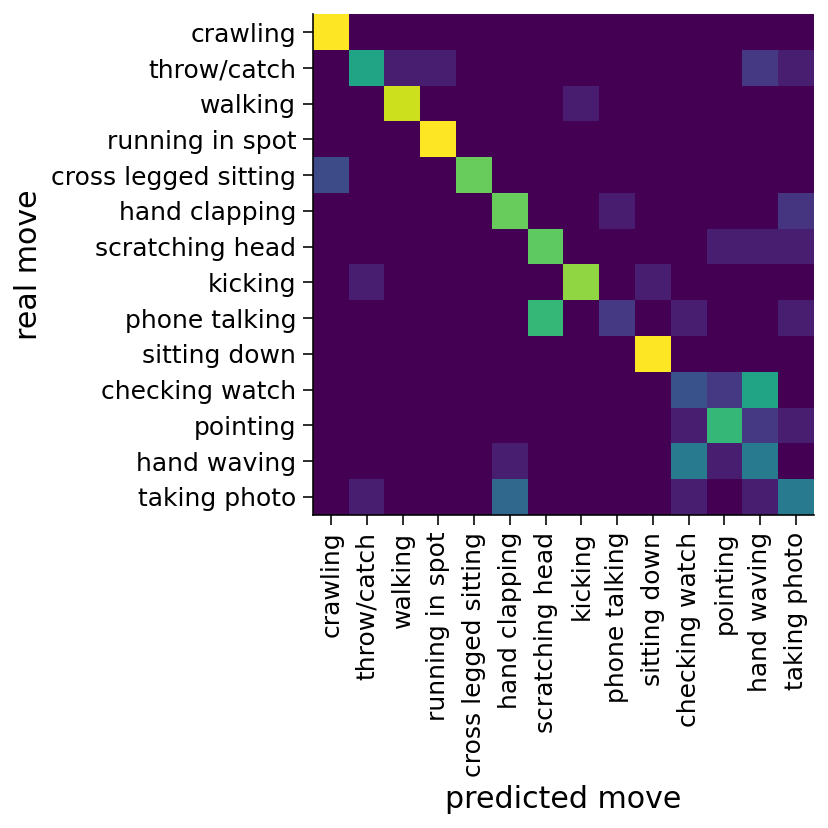

In [20]:
cnn6j = testJointModel(joints=[0, 10, 11, 15, 22, 23])
print(cnn6j['performance'])
plotConfusionMatrix(real_labels = cnn6j['real_labels'], predicted_labels = cnn6j['predicted_labels'], label_names=label_names)

That is some pretty good performance based on only 6 / 24 joints!

* Can we answer our question? --> YES, we can classify movement, and we can do so based on a sub-set of joints.
* Have we reached our goals? --> YES, this pilot study shows that we can decode movement type based on skeletal joint motion data.
* Can we evaluate our hypotheses? --> YES, we can now test the specific model performances and compare them.

Good news, looks like we're done with a first iteration of modeling!

---
# Step 9: Model evaluation

We can now see how well our model actual does, by running it to test our hypotheses. To test our hypotheses, we will group the joints into limbs:


In [21]:
limb_joints = {'Left Leg': [1, 4, 7, 10],
               'Right Leg': [2, 5, 8, 1],
               'Left Arm': [13, 16, 18, 20, 22],
               'Right Arm': [14, 17, 19, 21, 23],
               'Torso': [0, 3, 6, 9],
               'Head': [12, 15]}

Our second hypothesis was that since our participants are right handed, the right arm will give as better classification performance than the left arm. We will fit the model on each individual limb, and then we can compare performance on the left and right arm.

**This should take up to ~1 minute!**

In [22]:
limb_fits = {}
for limb in limb_joints.keys():
  print(f"\n*** FITTING: {limb}")

  joints = limb_joints[limb]
  limb_fit = testJointModel(joints=joints)
  limb_fits[limb] = limb_fit
  print(f"limb performance: {limb_fit['performance']:.2f}%")


*** FITTING: Left Leg
78.48837209302324

*** FITTING: Right Leg
76.74418604651163

*** FITTING: Left Arm
60.46511627906976

*** FITTING: Right Arm
37.7906976744186

*** FITTING: Torso
77.90697674418605

*** FITTING: Head
49.41860465116279


Every time we run this, we get something along these lines:

```
*** FITTING: LeftLeg
limb performance: 65.70%
*** FITTING: RightLeg
limb performance: 50.58%
*** FITTING: LeftArm
limb performance: 37.21%
*** FITTING: RightArm
limb performance: 22.09%
*** FITTING: Torso
limb performance: 73.84%
*** FITTING: Head
limb performance: 39.53%
```



For a formal test, you'd fit each model a number of times and let it converge by using many more epochs. We don't really have time for that here, but the pattern is fairly clear already. The head and arms are the worst, the legs are better, and the torso usually wins!

The left arm seems to outperform the right arm in classifying movements. That was not what we expected. Maybe we should repeat this with left-handed participants to see if their right arm works better?

We still want to test our first hypothesis, which we're not so certain about any more, given the performance above: the torso outperforms the other limbs. But that doesn't mean that a model with arms and legs only is necessarily worse than a model with arms, legs and head and torso as well.

We will test each of these models six times, and take the median performance.

**This takes up to ~4 minutes!** (About 2 minutes per kind of model.)

In [ ]:
limb_sets = {'limbs only':['Left Leg', 'Right Leg', 'Left Arm', 'Right Arm'],
             'limbs+torso+head':['Left Leg', 'Right Leg', 'Left Arm',
                                 'Right Arm', 'Torso', 'Head']}

for limb_set in limb_sets.keys():
  print(f"\n*** FITTING: {limb_set}")
  
  limbs = limb_sets[limb_set]

  joints = []
  for limb in limbs:
    joints += limb_joints[limb]

  performances = []
  for repeat in range(6):
    limb_set_fit = testJointModel(joints=joints)
    performances.append(limb_set_fit['performance'])
    print(f"performance: {limb_set_fit['performance']:.2f}%")
  
  print(f"median performance: {(np.median(performances)):.2f}%")


*** FITTING: limbs only
performance: 71.51%


The models are not converging, or perfect, but almost every time we run this cell the extra information from the torso and head do make the model perform a little better.

It seems that our spine is pretty fundamental for movement!

Maybe we should see how well we can do with a minimal number of joints measured. Can we go as low as 1 joint? For example, since we usually carry a phone in our pocket, the inertal motion units (IMU, i.e. accelerometers + gyroscopes) on a phone might be sufficient to get us some idea of movements people are making. We could test individual joints as well, or combinations of 2 or 3 joints.

Of course, in real life people make many more types of movements, so we might need more joints or IMU's for decent classification. It will also be a problem to figure out when one movement type has ended and the next has begun.

---
# Step 10: publication

Let's write a simple abstract following the guidelines...

**A. What is the phenomena**?  Here summarize the part of the phenomena which your modeling addresses.

_Movement is well characterized by angular joint information._

**B. What is the key scientific question?**:  Clearly articulate the question which your modeling tries to answer.

_Here, we ask how many joints are needed to accurately classify movements, and which joints are the most informative for classification._

**C. What was our hypothesis?**:  Explain the key relationships which we relied on to simulate the phenomena.

_We hypothesized that limb motion was more informative than torso motion; and we hypothesized that right side limbs carry more information about movement types than left side limbs._

**D. How did your modeling work?** Give an overview of the model, it's main components, and how the modeling works.  ''Here we ... ''

_To investigate these hypotheses, we constructed a simple 1d convolutional neuroal network (CNN) and trained it on different subsets of the publicly available MoVi dataset._

**E. What did you find? Did the modeling work?** Explain the key outcomes of your modeling evaluation. 

_Contrary to our expectations, we observed that the torso was more informative for classification then the rest of the joints. Furthermore the left limbs allowed for better classification than the right limbs._

**F. What can you conclude?** Conclude as much as you can _with reference to the hypothesis_, within the limits of the modeling. 

_We conclude that while our model works to classify movements from subsets of joint rotations, the specific subsets of joints that were most informative were counter to our intuition._

**G. What are the limitations and future directions?** What is left to be learned? Briefly argue the plausibility of the approach and/or what you think is essential that may have been left out.

_Since our dataset contained limited number of movement types, generalization might be limited. Furthermore, our findings might be specific for our particular choice of model. Finally, classification of continuous movement presents an additional challenge since we used already segmented motion data here._

>If we put this all in one paragraph, we have our final complete abstract. But, first, do not include the letters in _your_ abstract, and second, you might need to paraphrase the answers a little so they fit together.

<br>

**Abstract**

(A) Movement is well characterized by angular joint information. 
(B) Here, we ask how many joints are needed to accurately classify movements, and which joints are the most informative for classification.
(C) We hypothesized that limb motion was more informative than torso motion; and we hypothesized that right side limbs carry more information about movement types than left side limbs.
(D) To investigate these hypotheses, we constructed a simple 1d convolutional neuroal network (CNN) and trained it on different subsets of the publicly available MoVi dataset.
(E) Contrary to our expectations, we observed that the torso was more informative for classification then the rest of the joints. Furthermore the left limbs allowed for better classification than the right limbs.
(F) We conclude that while our model works to classify movements from subsets of joint rotations, the specific subsets of joints that were most informative were counter to our intuition.
(G) Since our dataset contained limited number of movement types, generalization might be limited. Furthermore, our findings might be specific for our particular choice of model. Finally, classification of continuous movement presents an additional challenge since we used already segmented motion data here.